---
# <div align="center"><font color='green'></font></div>
# <div align="center"><font color='green'>Machine Learning Assignment 2</font></div>
## <div align="center"> <font color='green'>Group Members: Shreyas Shah (s4005805), Duy Nguyen Hoang (s3978268)</font></div>
---

## Project Overview

This project focuses on developing image classification models using histopathology patch images from a colon cancer dataset. The goal is to automatically classify small tissue patches into medically relevant categories, which could help support pathologists in cancer diagnosis workflows.

---

## Target and Task Explanation

There are **two main classification tasks** in this project:

### 1. **Binary Classification Task** – `isCancerous` (Task 1)
- **Target Variable:** `isCancerous`  
- **Type:** Binary classification (`0 = Non-cancerous`, `1 = Cancerous`)
- **Goal:** Train a model that predicts whether a given tissue patch is cancerous or not.
- **Use Case:** Assists in early detection by filtering out non-cancerous tissue and highlighting potential cancer regions.

### 2. **Multi-Class Classification Task** – `cellTypeName` (Task 2)
- **Target Variable:** `cellTypeName`  
- **Type:** Multi-class classification (4 categories: `epithelial`, `inflammatory`, `fibroblast`, `others`)
- **Goal:** Build a model that predicts the type of cell present in the image.
- **Use Case:** Provides further insight into tissue structure and cellular makeup, which can improve pathology assessments and guide further analysis.

---

These tasks are performed using supervised learning, with models trained on labelled images. Both tasks require separate preprocessing and modelling strategies to handle different label types and class distributions.

## Loading Dataset and Data Splitting

### Reproducibility
- A fixed `random_state=42` is used throughout to make sure results are consistent every time the notebook is run.
- `np.random.seed(42)` makes NumPy operations predictable if they're used later.
- `keras.utils.set_random_seed(42)` ensures Keras training steps (like weight initialisation and dropout) are also repeatable.

### Train / Validation / Test Split (Patient-Aware)
- The dataset is split into 70% training, 20% validation, and 10% test using GroupShuffleSplit, based on `patientID`.
- This ensures that no patches from the same patient appear in multiple sets, which avoids data leakage and makes the model's performance more realistic.
- The split still maintains class balance using stratified group sampling logic.
- The training set provides enough data to learn features, the validation set helps with tuning and the test set gives a fair final evaluation using completely unseen patients.

In [15]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import GroupShuffleSplit

# Reproducibility
SEED = 42
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

# ---------------
# 2. Load the Data
# ---------------
DATA_DIR = 'Image_classification_data'
CSV_PATH = os.path.join(DATA_DIR, 'data_labels_mainData.csv')

# Read labels
data = pd.read_csv(CSV_PATH)
print(f"Total samples: {len(data)}")
data.head()

# Build absolute image paths
data['image_path'] = data['ImageName'].apply(
    lambda fname: os.path.join(DATA_DIR, 'patch_images', fname)
)

# ---------------
# 3. Train / Validation / Test Split (Patient-Aware)
# ---------------

# Split off test set (10%) using patient ID groups
splitter = GroupShuffleSplit(test_size=0.10, n_splits=1, random_state=SEED)
train_val_idx, test_idx = next(splitter.split(data, groups=data['patientID']))
train_val_data = data.iloc[train_val_idx]
test_data = data.iloc[test_idx]

# Split train and validation (remaining 90% → 70% train, 20% val)
splitter_val = GroupShuffleSplit(test_size=0.2222, n_splits=1, random_state=SEED)
train_idx, val_idx = next(splitter_val.split(train_val_data, groups=train_val_data['patientID']))
train_data = train_val_data.iloc[train_idx]
val_data = train_val_data.iloc[val_idx]

print(f"Train samples:      {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples:       {len(test_data)}")
print("Validation isCancerous counts:\n", val_data.isCancerous.value_counts())
print("Test     isCancerous counts:\n", test_data.isCancerous.value_counts())

Total samples: 9896
Train samples:      6643
Validation samples: 2375
Test samples:       878
Validation isCancerous counts:
 isCancerous
0    1200
1    1175
Name: count, dtype: int64
Test     isCancerous counts:
 isCancerous
0    493
1    385
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

### Plot Justifications

**Class Distribution (isCancerous)**
- A bar chart shows how many cancerous vs non-cancerous samples are in the training data.
- This helps check for class imbalance, which can make the model favour the more common class.
- Knowing this early helps decide whether to use class weights or data balancing techniques later.

**Cell-Type Distribution**
- A bar chart shows how often each cell type appears in the training data.
- This matters for Task 2, where the model needs to predict the cell type.
- If some cell types are rare, we might need to use augmentation or rebalancing to help the model learn them properly.

**Patient-Level Patch Counts**
- A histogram shows how many image patches come from each patient.
- Some patients have way more patches than others, which can cause the model to overfit to those patients.
- This could be important later when designing how to validate the model fairly.

**Sample Images per Class (isCancerous)**
- Five example images from each class are shown to visually check the dataset.
- This helps spot any obvious issues like wrong labels, corrupted images or weird patterns.
- It also shows whether the two classes (cancerous vs non-cancerous) look different enough for a model to learn from.

**Sample Images per Cell Type**
- Three sample images are shown for each cell type.
- This gives a quick look at whether the cell types have clear visual differences.
- If some types look very similar, the model might need extra help to tell them apart, like more features or better augmentation.


Class distribution in training set:
isCancerous
0    4124
1    2519
Name: count, dtype: int64


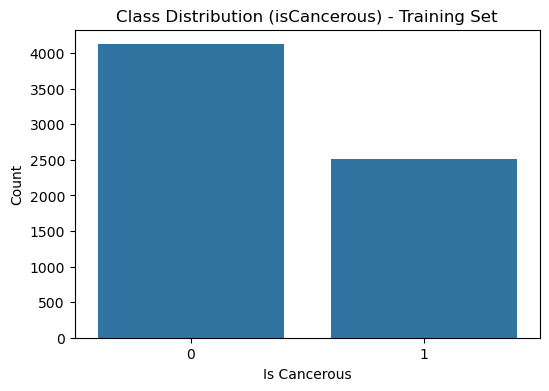


Cell-type distribution in training set:
cellTypeName
epithelial      2519
inflammatory    1924
fibroblast      1192
others          1008
Name: count, dtype: int64


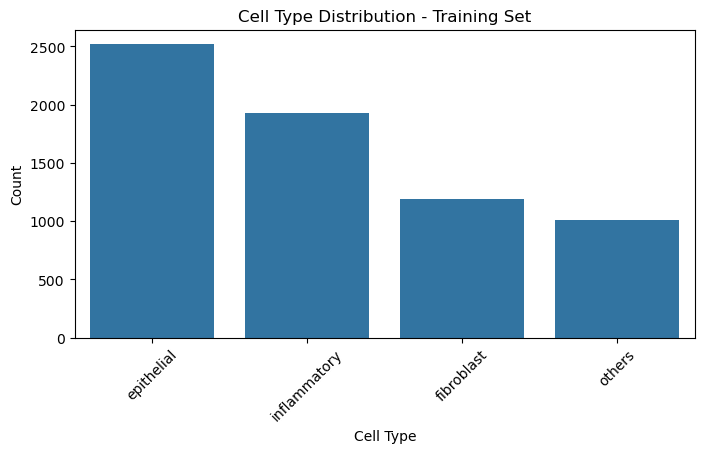

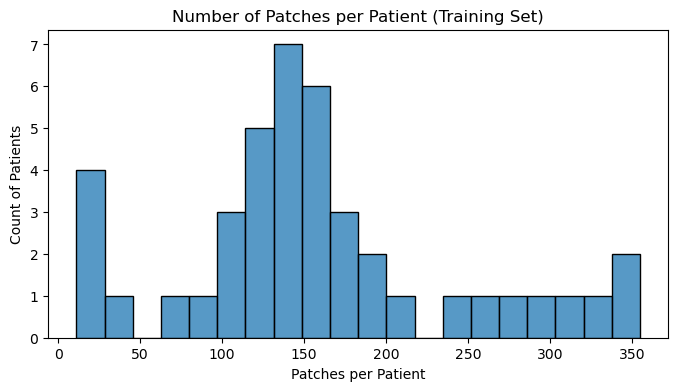

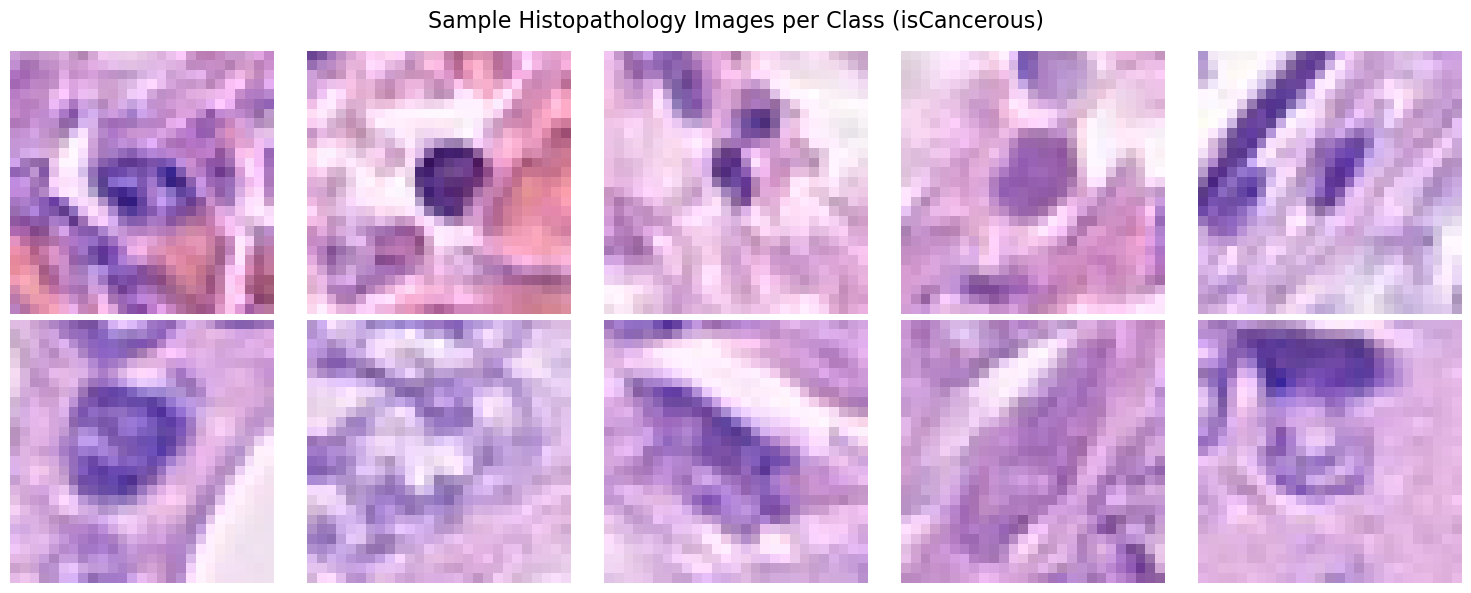

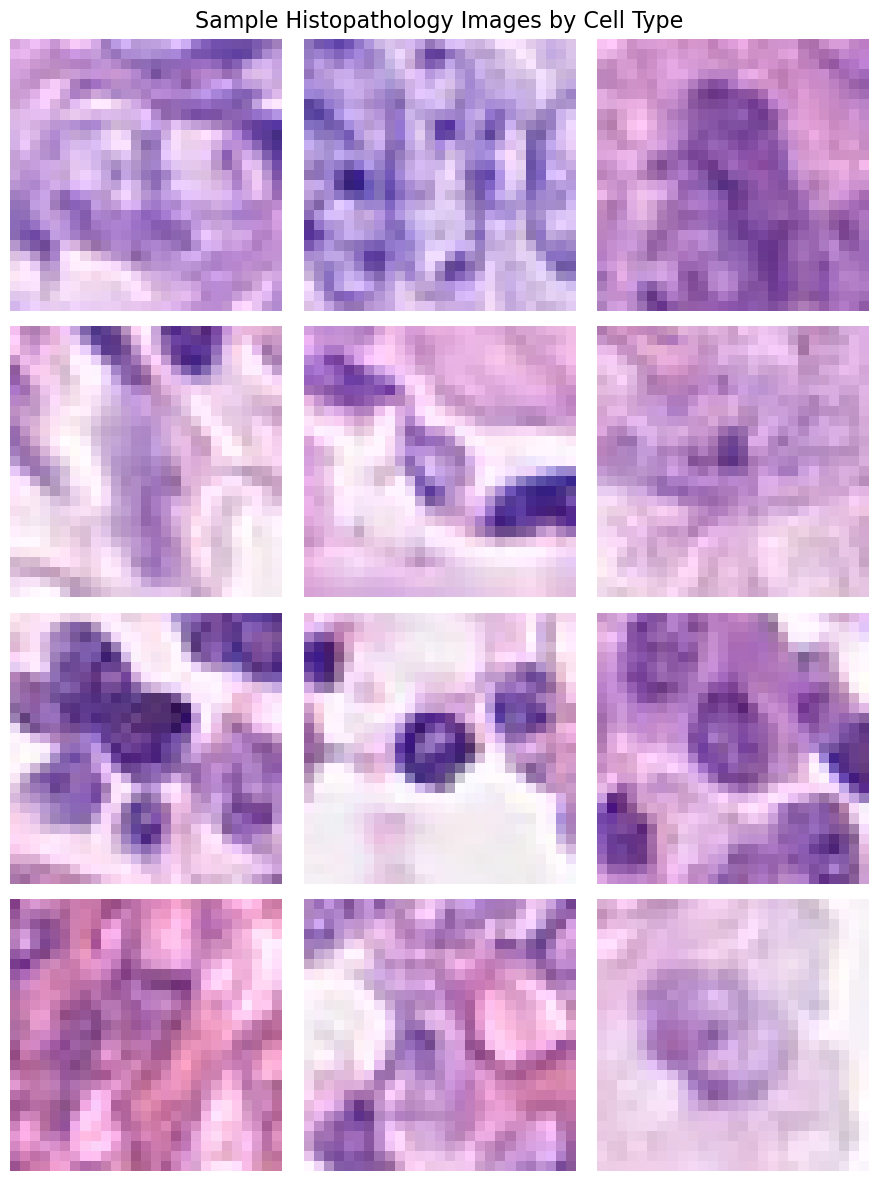

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Class Distribution (isCancerous)
print("\nClass distribution in training set:")
print(train_data['isCancerous'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x='isCancerous', data=train_data)
plt.title('Class Distribution (isCancerous) - Training Set')
plt.xlabel('Is Cancerous')
plt.ylabel('Count')
plt.show()

# Cell-Type Distribution
print("\nCell-type distribution in training set:")
print(train_data['cellTypeName'].value_counts())
plt.figure(figsize=(8, 4))
sns.countplot(
    x='cellTypeName',
    data=train_data,
    order=train_data['cellTypeName'].value_counts().index
)
plt.title('Cell Type Distribution - Training Set')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Patient-Level Patch Counts
plt.figure(figsize=(8, 4))
sns.histplot(train_data['patientID'].value_counts(), bins=20, kde=False)
plt.title('Number of Patches per Patient (Training Set)')
plt.xlabel('Patches per Patient')
plt.ylabel('Count of Patients')
plt.show()


# Sample Images per Class
sample_data = train_data.groupby('isCancerous').sample(n=5, random_state=SEED)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for (cls, grp), ax_row in zip(sample_data.groupby('isCancerous'), axes):
    for img_path, ax in zip(grp['image_path'].values, ax_row):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
    ax_row[0].set_ylabel(f'Class {cls}', size='large')
plt.suptitle('Sample Histopathology Images per Class (isCancerous)', size=16)
plt.tight_layout()
plt.show()

# Sample Images per Cell Type
sample_by_type = train_data.groupby('cellTypeName').sample(3, random_state=SEED)
fig, axes = plt.subplots(len(sample_by_type['cellTypeName'].unique()), 3, figsize=(9, 12))
for (ctype, grp), row_axes in zip(sample_by_type.groupby('cellTypeName'), axes):
    for img_path, ax in zip(grp['image_path'], row_axes):
        ax.imshow(mpimg.imread(img_path))
        ax.axis('off')
    row_axes[0].set_ylabel(ctype, size='large')
plt.suptitle('Sample Histopathology Images by Cell Type', size=16)
plt.tight_layout()
plt.show()


> <span style="font-size:1em;">✔</span> **EDA Observations**

> **Dataset Overview**
> - The dataset has a total of 9,896 labelled images.
> - After applying a patient-aware split, the dataset was divided into 6,643 training samples, 2,375 validation samples and 878 test samples.  
> - Patient-aware splitting means all patches from one patient are only in one of the sets. This helps avoid data leakage and gives a more realistic test of how well the model generalises to new patients.

> **Class Distribution (`isCancerous`)**
> - As seen in the class distribution plot above, the training set has 4,124 non-cancerous and 2,519 cancerous images.
> - There is some class imbalance (more non-cancerous images), but it’s not extreme.
> - This imbalance could still affect the model, so using class weights during training might help improve results.

> **Validation and Test Class Distribution**
> - Looking at the validation and test set statistics, the validation set has 1,200 non-cancerous and 1,175 cancerous samples.
> - The test set has 493 non-cancerous and 385 cancerous samples.
> - The proportions are similar to the training set, which shows the split kept the class balance consistent.

> **Cell-Type Distribution**
> - From the cell-type bar chart, the most common cell type is epithelial (2,519 samples), followed by inflammatory (1,924), fibroblast (1,192), and others (1,008).
> - Some types have fewer samples, especially “others”.
> - This imbalance might make it harder for the model to learn from those classes. Extra data, augmentation, or class weighting could help.

> **Patient-Level Patch Distribution**
> - As shown in the histogram, some patients contribute over 300 image patches, while others have far fewer.
> - This could make the model focus too much on certain patients’ data and overfit.
> - Splitting by patient (as done here) reduces this risk and helps the model learn more general features.

> **Sample Images per Class (`isCancerous`)**
> - From the image samples above, 10 sample images were shown (5 for each class).
> - Cancerous images usually show darker and more irregular patterns. Non-cancerous ones are lighter and more even.
> - These visual differences show that it should be possible for a model to learn to tell the classes apart.

> **Sample Images per Cell Type**
> - Likewise, 12 sample images were shown (3 for each of the 4 cell types).
> - The cell types look different — for example, epithelial cells appear rounder, while fibroblasts are more stretched.
> - These differences support the idea that a multi-class classification model can work well here.

> **Additional Dataset Acknowledgement**
> - There is another file (`data_labels_extraData.csv`) with over 10,000 more labelled images.
> - This will be used later in the modelling phase to help improve results, especially for the cell-type classification task.

## Data Pre-Processing

**Missing Value Check**
- The dataset was checked for missing values in important columns like image names, labels, and patient IDs.
- This is to make sure there are no empty or broken rows that could cause errors later during training.
- No missing values were found, so no rows needed to be removed.

**Normalisation**
- All image pixel values are scaled from the range [0, 255] to [0, 1] using `rescale=1./255`.
- This is a common and important step in image models because it helps the model learn faster and more smoothly.
- Without this, the large pixel values might slow down training or make it unstable.

**Data Augmentation (Training Set Only)**
- Data augmentation is used to make the training data more varied by randomly changing the images in small ways.
- These changes include rotating, zooming, shifting, shearing and flipping the images.
- It helps the model learn to recognise patterns in different positions and makes it less likely to overfit.
- These changes happen during training, so each epoch the model sees slightly different versions of the same images.

**Validation and Test Rescaling Only**
- The validation and test sets are only rescaled to [0, 1] but are not augmented.
- This keeps them consistent and realistic, so the model is tested on clean data.

**Image Size and Batch Size**
- All images are resized to 27 × 27 pixels to match what the model expects as input.
- A batch size of 32 is used to train efficiently while staying within memory limits.

**Data Generator Setup**
- `flow_from_dataframe()` is used to load the images from the dataset and apply the preprocessing steps on the fly.
- For predicting `isCancerous` (binary classification task), the class_mode='binary' setting is used, which prepares the labels for binary output (0 or 1).
- For predicting `cellTypeName` (multi-class task), the class_mode='categorical' setting is used, which automatically turns the labels into one-hot encoded vectors.

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------------
# Missing Value Check
# -------------------------------
# Check if any key columns are missing values before proceeding
print("Missing values in dataset:\n", data[['ImageName', 'cellTypeName', 'isCancerous', 'patientID']].isnull().sum())

# -------------------------------
# Normalisation and Augmentation
# -------------------------------
# All pixel values are rescaled to [0, 1]
# Data augmentation is applied only to the training set to improve generalisation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test sets should not be augmented but only rescaled
val_test_datagen = ImageDataGenerator(rescale=1./255)

# ----------------------
# Image flow parameters
# ----------------------
IMG_SIZE = (27, 27)
BATCH_SIZE = 32

# ----------------------
# Data Generators Setup for isCancerous
# ----------------------

# Convert isCancerous column to string first
train_data.loc[:, 'isCancerous'] = train_data['isCancerous'].astype(str)
val_data.loc[:, 'isCancerous'] = val_data['isCancerous'].astype(str)
test_data.loc[:, 'isCancerous'] = test_data['isCancerous'].astype(str)

# Training generator for isCancerous with augmentation
train_generator_isCancerous = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='isCancerous',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

# Validation generator for isCancerous (no augmentation)
val_generator_isCancerous = val_test_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='isCancerous',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Test generator for isCancerous (no augmentation)
test_generator_isCancerous = val_test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='isCancerous',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ----------------------
# Data Generators Setup for cellTypeName
# ----------------------

# Flowing training data with augmentation
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='cellTypeName',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Flowing validation data (no augmentation)
val_generator = val_test_datagen.flow_from_dataframe(
    val_data,
    x_col='image_path',
    y_col='cellTypeName',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Flowing test data (no augmentation)
test_generator = val_test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='cellTypeName',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Missing values in dataset:
 ImageName       0
cellTypeName    0
isCancerous     0
patientID       0
dtype: int64
Found 6643 validated image filenames belonging to 2 classes.
Found 2375 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.
Found 6643 validated image filenames belonging to 4 classes.
Found 2375 validated image filenames belonging to 4 classes.
Found 878 validated image filenames belonging to 4 classes.


## Base Model Selection and Justification - `isCancerous` (Binary Classification)

- A Convolutional Neural Network (CNN) is selected as the base model to predict whether an image patch is cancerous or not.
- CNNs are highly effective at handling image-based data, as they can learn important visual features (like edges, textures, and patterns) using convolutional filters.
- These features are critical in histopathology images where cancerous tissues may have subtle structural differences.

---

### Performance Metrics Selection
- From the **EDA**, the training set contains 4,124 non-cancerous and 2,519 cancerous samples, showing a class imbalance (non-cancerous is more common).
- Because of this imbalance, accuracy is not a reliable metric – a model predicting mostly non-cancerous could still achieve high accuracy but miss many true cancer cases.
- The following metrics are used to properly evaluate the performance:
- **F1-score**: The F1-score combines both precision and recall into a single value. It is chosen as the main performance metric because the dataset is slightly imbalanced (more non-cancerous than cancerous samples).
- **Precision:** Measures how many of the predicted “cancerous” samples are actually correct. This reduces false positives, which is important in medical settings to avoid unnecessary further testing.
- **Recall:** Measures how many of the actual “cancerous” samples the model correctly identified. High recall is essential for safety-critical tasks like cancer detection where missing a positive case is risky.
- **Confusion Matrix**: Helps clearly identify where the model is making correct and incorrect predictions for each class. Provides detailed insight into false positives and false negatives, which is particularly important in cancer prediction where missing a cancerous case is critical.
- **ROC AUC Score:** Measures the model’s ability to separate the two classes across all thresholds. A high ROC AUC means the model is good at distinguishing cancerous from non-cancerous images regardless of the threshold chosen.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,937 (1.13 MB)

 Trainable params: 295,937 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5578 - precision: 0.6742 - recall: 0.4704 - val_loss: 0.4126 - val_precision: 0.9517 - val_recall: 0.6204
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3454 - precision: 0.8100 - recall: 0.7940 - val_loss: 0.5419 - val_precision: 0.9583 - val_recall: 0.5089
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3028 - precision: 0.8460 - recall: 0.8266 - val_loss: 0.6219 - val_precision: 0.9679 - val_recall: 0.4877
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2889 - precision: 0.8467 - recall: 0.8353 - val_loss: 0.4252 - val_precision: 0.9511 - val_recall: 0.6621
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3005 - precision: 0.8289 - recall: 0.8299 - val_loss: 0.6952 - val_precision: 0.9732 - val_recall: 0.4323
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2894 - precision: 0.8322 - recall: 0.8276 - val_loss: 0.3249 - val_precision: 0.9327 - val_recall:

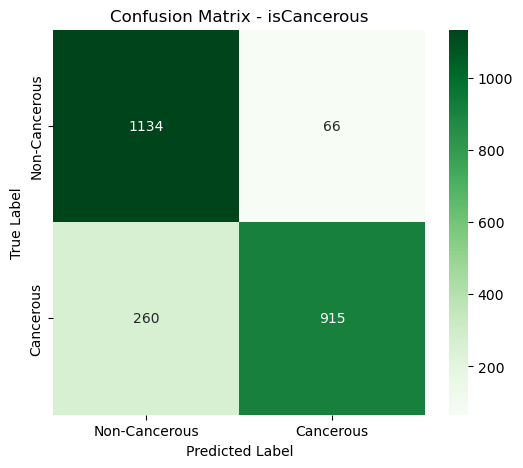

ROC AUC Score (isCancerous): 0.95


In [34]:
# -----------------------------------
# Base CNN Model for isCancerous Classification (Binary)
# -----------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define input shape
INPUT_SHAPE = (27, 27, 3)

# Build the CNN model
model_isCancerous = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_isCancerous.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[Precision(name='precision'), Recall(name='recall')]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Display model summary
model_isCancerous.summary()

# ----------------------
# Train the isCancerous Model
# ----------------------
history_cancer = model_isCancerous.fit(
    train_generator_isCancerous,
    epochs=30,
    validation_data=val_generator_isCancerous,
    callbacks=[early_stop]
)

# -----------------------------------
# Evaluation of isCancerous Model
# -----------------------------------

# Predict class probabilities
y_pred_probs_cancer = model_isCancerous.predict(val_generator_isCancerous)

# Convert to binary labels
y_pred_classes_cancer = (y_pred_probs_cancer > 0.5).astype(int)

# True labels
y_true_cancer = val_generator_isCancerous.classes

# ------------------------
# Classification Report
# ------------------------
print("Classification Report (isCancerous):")
print(classification_report(y_true_cancer, y_pred_classes_cancer, target_names=['Non-Cancerous', 'Cancerous']))

# ------------------------
# Confusion Matrix
# ------------------------
cm_cancer = confusion_matrix(y_true_cancer, y_pred_classes_cancer)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_cancer, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Cancerous', 'Cancerous'],
            yticklabels=['Non-Cancerous', 'Cancerous'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - isCancerous')
plt.show()

# ------------------------
# ROC AUC Score
# ------------------------
roc_auc_cancer = roc_auc_score(y_true_cancer, y_pred_probs_cancer)
print(f"ROC AUC Score (isCancerous): {roc_auc_cancer:.2f}")

> <span style="font-size:1em;">✔</span> **Observations – `isCancerous` Base Model**
> 
> **Model Summary**
> - The CNN model has a total of ~295,937 trainable parameters, making it lightweight and suitable for fast experimentation.
> - The architecture includes one convolutional layer, max pooling, a flattening layer, a dense hidden layer, and a final sigmoid output for binary classification.
> - This simple structure supports efficient training while still allowing the model to learn relevant spatial features from the histopathology images.
> 
> **Training and Validation Performance**
> - The training precision and recall improved steadily across 11 epochs, stabilising at ~0.85–0.86.
> - Validation precision remained high throughout (~0.94–0.97), indicating the model is confident and often correct when it predicts cancer.
> - Validation recall fluctuated between 0.55 and 0.86, meaning the model occasionally misses actual cancerous samples.
> - These recall drops may stem from the class imbalance or model underfitting minority cases, suggesting class weighting or a deeper network may help.
> 
> **Classification Report**
> - Precision for the cancerous class was high (~0.94), indicating few false positives.
> - Recall for the cancerous class was lower (~0.74), showing the model missed several actual positives.
> - The F1-score for the cancerous class was ~0.83, confirming the model balances sensitivity and specificity reasonably well.
> 
> **Confusion Matrix**
> - The confusion matrix shows most predictions were correct, but a notable number of cancerous images were classified as non-cancerous (false negatives).
> - Reducing false negatives is essential in cancer detection, so recall improvements should be a priority in future models.
> 
> **ROC AUC Score**
> - The model achieved a ROC AUC score of ~0.96, meaning it has strong class separability across thresholds.
> - This high score supports that the model is generally good at distinguishing between the two classes, even with class imbalance.

## Base Model Selection and Justification – `cellTypeName` (Multi-Class Classification)
- A **CNN** is selected as the base model for this task because it needs to distinguish between four visually distinct cell types.
- CNNs are well-suited for image classification as they automatically learn spatial hierarchies and features such as edges, textures, and cell morphology.
- In histopathology, where visual cues like shape, density, and structure vary between cell types (e.g., epithelial vs fibroblast), CNNs can capture these patterns effectively.

---

### Performance Metrics Selection
- The training set is imbalanced: some classes (like epithelial) have many more samples than others (like others).
- Specifically, the EDA shows that the epithelial class has 2,519 samples, while the 'others' class has only 1,008, confirming a notable imbalance across the four cell types.
- In multi-class settings with imbalance, using accuracy is misleading – a model that just predicts the most common class can still appear accurate.

- To evaluate performance more fairly, the following metrics are used:

    - **Macro F1-score:** Gives equal importance to all classes, making it a fairer evaluation when classes are not evenly distributed. It is chosen as the main metric because it treats all classes equally, ensuring that under-represented cell types (e.g., ‘others’) are not ignored during evaluation.
    - **Precision:** Measures how many predicted samples for each class are correct. This helps check if the model is wrongly predicting one class too often.
    - **Recall:** Measures how many actual samples of each class are correctly identified. Low recall for rare classes shows that the model may be ignoring them.
    - **Confusion Matrix:** Provides a visual summary of prediction performance by class, showing which classes are being misclassified. It is particularly helpful for identifying if the model struggles to distinguish between visually similar cell types (e.g., fibroblast vs others).
    - **Macro-average ROC AUC Score:** Computes the average ROC AUC across all classes treating each class equally, which avoids bias toward frequent classes and gives a balanced view of separability between each class vs the rest.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,132 (1.13 MB)

 Trainable params: 296,132 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.1842 - precision: 0.6667 - recall: 0.1748 - val_loss: 0.9199 - val_precision: 0.7002 - val_recall: 0.4926
Epoch 2/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8721 - precision: 0.7704 - recall: 0.4917 - val_loss: 1.4759 - val_precision: 0.3484 - val_recall: 0.2366
Epoch 3/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8176 - precision: 0.7793 - recall: 0.5464 - val_loss: 0.8159 - val_precision: 0.7398 - val_recall: 0.5482
Epoch 4/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7699 - precision: 0.7723 - recall: 0.5891 - val_loss: 1.1915 - val_precision: 0.5209 - val_recall: 0.3781
Epoch 5/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7336 - precision: 0.7848 - recall: 0.6252 - val_loss: 0.9365 - val_precision: 0.6616 - val_recall: 0.5482
Epoch 6/30
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.7283 - precision: 0.7901 - recall: 0.6293 - val_loss: 1.0638 - val_precision: 0.5983 - val_recall: 0.4867
Ep

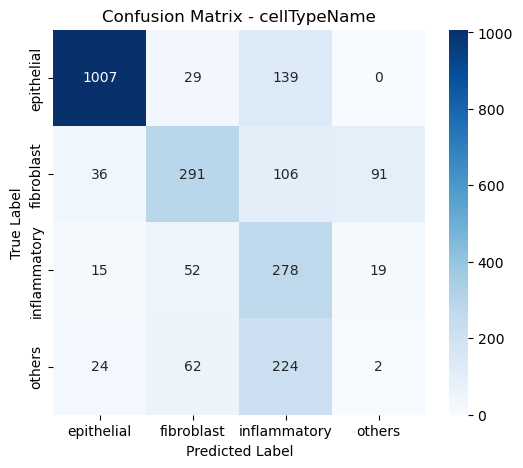

Macro-average ROC AUC Score (cellTypeName): 0.85


In [33]:
# -----------------------------------
# Base CNN Model for cellTypeName Classification (Multi-Class)
# -----------------------------------
NUM_CLASSES = 4

model_cellType = Sequential([
    Input(shape=INPUT_SHAPE),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model_cellType.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[Precision(name='precision'), Recall(name='recall')]
)

model_cellType.summary()

# Train cellType model
history_cellType = model_cellType.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop]
)

# Evaluation
y_pred_probs_type = model_cellType.predict(val_generator)
y_pred_classes_type = np.argmax(y_pred_probs_type, axis=1)
y_true_type = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("Classification Report (cellTypeName):")
print(classification_report(y_true_type, y_pred_classes_type, target_names=class_labels))

cm_type = confusion_matrix(y_true_type, y_pred_classes_type)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_type, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - cellTypeName')
plt.show()

# ROC AUC Score (multi-class)
y_true_binarized = label_binarize(y_true_type, classes=[0, 1, 2, 3])
roc_auc_type = roc_auc_score(y_true_binarized, y_pred_probs_type, average='macro', multi_class='ovr')
print(f"Macro-average ROC AUC Score (cellTypeName): {roc_auc_type:.2f}")

> <span style="font-size:1em;">✔</span> **Observations – `cellTypeName` Base Model**
>
> **Model Summary**
> - The CNN model has ~296,132 trainable parameters, making it lightweight and efficient for multi-class image classification.
> - The architecture includes one convolutional layer, a max pooling layer, a flattening layer, a dense hidden layer, and a softmax output layer to handle the four target classes.
>
> **Training and Validation Metrics**
> - Training precision increased to ~0.79 and recall to ~0.65 by the final epoch.
> - Validation precision peaked at ~0.63 and validation recall at ~0.65.
> - This suggests that the model is learning relevant patterns but still struggles slightly with recall across all classes, especially due to class imbalance.
>
> **Classification Report**
> - The epithelial class achieved a high F1-score of ~0.89, indicating strong model performance for the majority class.
> - The fibroblast class had a moderate F1-score of ~0.61, while inflammatory achieved ~0.50.
> - The “others” class had a very low F1-score of ~0.01, showing that the model struggles significantly with this underrepresented class.
> - The overall macro F1-score was ~0.50, confirming that performance is not equally distributed across all classes.
>
> **Confusion Matrix**
> - Most epithelial images (~1,007) were correctly classified, but ~139 were misclassified as inflammatory.
> - The model confuses inflammatory with fibroblast and others, which might be due to overlapping visual features.
> - “Others” was mostly misclassified, especially as inflammatory (~224 times), further confirming the poor performance on this class.
>
> **ROC AUC Score**
> - The macro-average ROC AUC score was ~0.85, indicating that the model can moderately separate each class from the rest.
> - This score is promising, but further improvements are needed, especially for minority classes like “others”.

# References
https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed </br>
https://matplotlib.org/stable/api/image_api.html </br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html </br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator